### Multi-Target Predictions | Feature Selection Via ANOVA or t-tests

#### Import necessary libraries

In [1]:
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

import mlflow
import mlflow.sklearn
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Import Utility Functions
from model_utils import classify_skewness, transform_features_for_skewness, transform_targets
from model_utils import range_without_outliers, remove_outliers
from model_utils import SkewnessTransformer
from model_utils import categorical_value_counts_to_df, group_low_frequency_categories

# DAGSHUB
# import dagshub
# dagshub.init(repo_owner="Omdena", repo_name="IPage")

import warnings
warnings.filterwarnings("ignore")

#### Columns To Drop

In [2]:
COLS_TO_DROP = ["longitude", "latitude"]

#### Hyperparameters and Other definitions

In [3]:
MODEL_ESTIMATOR_ALPHA: list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
MODEL_ESTIMATOR_DEPTH: list[int] = [4, 6, 8]
MODEL_ESTIMATOR_NUM_LEAVES: list[int] = [31, 50]
MODEL_ESTIMATOR_MAX_DEPTH: list[int] = [5, 10, 15]
MODEL_ESTIMATOR_N_ESTIMATORS_RF: list[int] = [100, 200]
MODEL_ESTIMATOR_N_ESTIMATORS_ADA: list[int] = [50, 100]
MODEL_ESTIMATOR_N_ESTIMATORS_BAGGING: list[int] = [10, 50]
MODEL_ESTIMATOR_N_NEIGHBORS: list[int] = [5, 10]
MODEL_ESTIMATOR_C_SVR: list = [0.1, 1, 10]
CATBOOST_LEARNING_RATE: list = [0.0001, 0.001, 0.01, 0.1]

NUM_SIMPLE_IMPUTER: str = "mean"
CAT_SIMPLE_IMPUTER: str = "most_frequent"
ONE_HOT_ENCODER_HANDLE_UNKNOWN: str = "ignore"
MIN_SAMPLE_LEAF: list[int] = [1, 3, 5, 7]
POWER_TRANSFORMER_METHOD: str = "yeo-johnson"
CV: int = 10
# GRIDSEARCHCV_SCORING: str = "neg_mean_absolute_error"
GRIDSEARCHCV_SCORING: str = "neg_root_mean_squared_error"
RANDOM_STATE: int = 0
TRAIN_SIZE: float = 0.7
TEST_SIZE: float = 0.2
VAL_SIZE: float = 0.1
N_REPEATS: int = 10

MODEL_SAVE_PATH: str = f"./checkpoints/trained_multiple_models/"
BEST_MODEL_SUMMARY_CSV_PATH: str = f"./"
DATASET_VERSION: str = "v3"
SAVE_SUMMARY_TO_CSV: str = "True"

# Make dir if it doesn't exist
Path(MODEL_SAVE_PATH).mkdir(parents=True, exist_ok=True)
# Path(BEST_MODEL_SUMMARY_CSV_PATH).mkdir(parents=True, exist_ok=True)

# # MLflow experiment setup
# URI = "http://127.0.0.1:5000"
# mlflow.set_experiment(f"Maz | IPage")
# mlflow.set_tracking_uri(URI)

#### Load Dataset

In [4]:
file_path = f"../../../data/merged_{DATASET_VERSION}.csv"
# Create a Path object
data_file_path = Path(file_path)
data = pd.read_csv(data_file_path)

df = data.copy()

In [5]:
# print(f"Dataset: {df.head()}")
df.head()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
0,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.0,1.27,0.08,0.15,19.6,37.7,0.26,0.86,33.0,33.0,33.0
1,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.9,1.47,0.09,0.25,4.1,32.0,0.25,0.75,33.0,33.0,33.0
2,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,4.6,1.07,0.05,0.09,13.3,13.5,0.27,0.95,33.0,33.0,33.0
3,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.2,1.51,0.06,0.30,20.2,30.0,0.28,1.00,33.0,33.0,33.0
4,89.2767,25.5678,Mithpukur,belab,high ground,Clay loam,5.3,1.08,0.11,0.17,20.5,27.8,0.30,1.04,33.0,33.0,33.0


In [6]:
length_df = len(df)
print(f"Length of Dataset: {length_df}")

Length of Dataset: 2584


In [7]:
df.describe()

,longitude,latitude,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay
count,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000
mean,22.979895,12.711743,5.869107,1.002453,0.070375,0.238226,8.586086,8.843246,0.113593,1.187543,56.202786,22.819659,20.175310
std,31.597277,6.212016,0.518722,0.626685,0.039282,0.140441,9.266400,5.267589,0.132118,0.470586,10.998711,7.472131,5.535707
min,4.430300,8.039070,4.100000,0.100000,0.000800,0.000000,0.060000,0.650000,0.001611,0.080000,20.000000,10.000000,10.000000
25%,6.972760,9.251048,5.536365,0.553925,0.040000,0.138462,3.664697,5.668802,0.024444,0.879671,51.000000,18.000000,16.000000
50%,8.617840,9.971485,5.913315,0.807029,0.062176,0.209134,5.714590,7.243420,0.060213,1.143550,58.000000,20.000000,20.000000
75%,10.430405,11.159215,6.226348,1.290080,0.092213,0.313721,9.579792,10.298875,0.154269,1.443010,64.000000,24.000000,22.000000
max,89.416700,25.850000,7.945400,4.480000,0.257264,0.990000,74.500000,39.700000,0.990000,4.000000,80.000000,40.000000,60.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longitude   2584 non-null   float64
 1   latitude    2584 non-null   float64
 2   Area        2584 non-null   object 
 3   Soil group  2584 non-null   object 
 4   Land class  2584 non-null   object 
 5   Soil type   2584 non-null   object 
 6   pH          2584 non-null   float64
 7   SOC         2584 non-null   float64
 8   Nitrogen    2584 non-null   float64
 9   Potassium   2584 non-null   float64
 10  Phosphorus  2584 non-null   float64
 11  Sulfur      2584 non-null   float64
 12  Boron       2584 non-null   float64
 13  Zinc        2584 non-null   float64
 14  Sand        2584 non-null   float64
 15  Silt        2584 non-null   float64
 16  Clay        2584 non-null   float64
dtypes: float64(13), object(4)
memory usage: 343.3+ KB


In [9]:
print(df.isnull().values.any())
print(df.isnull().sum().sum())
print("\n")
print(df.isnull().sum())

False
0


longitude     0
latitude      0
Area          0
Soil group    0
Land class    0
Soil type     0
pH            0
SOC           0
Nitrogen      0
Potassium     0
Phosphorus    0
Sulfur        0
Boron         0
Zinc          0
Sand          0
Silt          0
Clay          0
dtype: int64


In [10]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())

0


#### Drop Columns 

In [11]:
# df.drop(COLS_TO_DROP, axis=1).describe()

#### Drop raw longitude and latitude if present

In [13]:
# if 'longitude' in features and 'latitude' in features:
#     features.remove(COLS_TO_DROP[0])
#     features.remove(COLS_TO_DROP[1])

#### Define target variable and features

In [12]:
targets = ["Boron", "Zinc", "SOC"]
features = [col for col in df.columns if col not in targets]

In [14]:
print(f"Targe: {targets}")
print(f"Features: {features}")

Targe: ['Boron', 'Zinc', 'SOC']
Features: ['longitude', 'latitude', 'Area', 'Soil group', 'Land class', 'Soil type', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


#### Identify categorical and numerical features

In [15]:
categorical_features = df[features].select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df[features].select_dtypes(include=['number']).columns.tolist()

In [16]:
print(f"Categorical Features:\n {categorical_features}\n")
print(f"Numerical Features:\n {numerical_features}\n")

Categorical Features:
 ['Area', 'Soil group', 'Land class', 'Soil type']

Numerical Features:
 ['longitude', 'latitude', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']



#### Targets

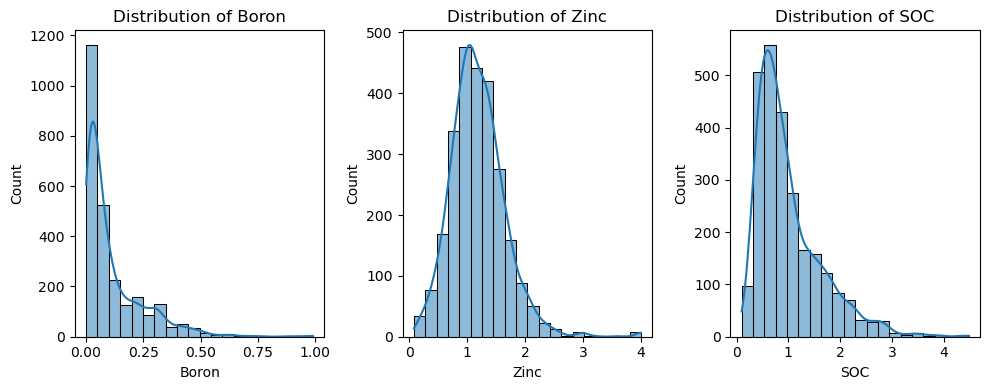

In [17]:
# Set up the number of rows and columns
num_targets = len(targets)
cols = 3  # Number of columns per row
rows = (num_targets + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 4))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, target in enumerate(targets):
    sns.histplot(df[target], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {target}")

# Remove unused subplots
for i in range(len(targets), len(axes)):
    fig.delaxes(axes[i])

# Adjust Layout
plt.tight_layout()
plt.show()

##### 1. Check for Skewnes in Targets

In [18]:
# Check skewness and provide recommendations
for target in targets:
    skewness = df[target].skew()
    skewness_category, recommendation = classify_skewness(skewness)
    print(f"Skewness of '{target}': {skewness:.4f}")
    print(f"  Skewness Category: {skewness_category}")
    print(f"  Recommendation: {recommendation}")
    print("-" * 100)

Skewness of 'Boron': 2.1046
  Skewness Category: Highly Skewed
  Recommendation: Recommend Log Transformation (if positive) or Yeo-Johnson
----------------------------------------------------------------------------------------------------
Skewness of 'Zinc': 1.0997
  Skewness Category: Moderately Skewed
  Recommendation: Recommend Yeo-Johnson Transformation
----------------------------------------------------------------------------------------------------
Skewness of 'SOC': 1.5057
  Skewness Category: Moderately Skewed
  Recommendation: Recommend Yeo-Johnson Transformation
----------------------------------------------------------------------------------------------------


#### 1. Analyze Ccategorical_features

In [19]:
print(f"Unique Values in 'Area' col:\n {df['Area'].unique()}\n")
print("*" * 120)
print(f"Unique Values in 'Soil group' col:\n {df['Soil group'].unique()}\n")
print("*" * 120)
print(f"Unique Values in 'Land class' col\n: {df['Land class'].unique()}\n")
print("*" * 120)
print(f"Unique Values in 'Soil type' col\n: {df['Soil type'].unique()}\n")

Unique Values in 'Area' col:
 ['Mithpukur' 'Pirgacha ' 'Gangachara' 'Kaunia upazila' 'Taraganj Thana'
 'Bauchi' 'Taraba' 'Plateau' 'Kaduna' 'Nasarawa' 'Niger' 'Kebbi' 'Kano'
 'Kwara' 'Katsina' 'Adamawa']

************************************************************************************************************************
Unique Values in 'Soil group' col:
 ['belab' 'Noadda' 'Sahapur' 'the moon' 'the pen' 'Khilgaon' 'Pirgacha'
 'Palashbari' 'Berries' 'Gangachara' 'Kaunia' 'Imadpur'
 'Alluvial soil of Teesta' 'Teesta sandy soil' 'Kachna' 'The militants'
 'Chilmari' 'Saghata' 'recession' 'Menanagar' 'Bhimpur' 'Indrail' 'isda']

************************************************************************************************************************
Unique Values in 'Land class' col
: ['high ground' 'Medium high land' 'Medium low land'
 'Deep medium high land' 'Shallow to medium high land' 'isda']

*******************************************************************************************

In [20]:
# Get the value counts in Categorical Columns of DataFrame
counts_df = categorical_value_counts_to_df(df)
# Print the resulting DataFrame
print(f"Categorical Value Counts")
print("*" * 24, "\n")
# print(counts_df)
counts_df

Categorical Value Counts
************************ 



,Categorical Feature,Sub-Category,Each Count,Total Unique Count
0,Area,Niger,561,16
1,Area,Kaduna,402,16
2,Area,Plateau,359,16
3,Area,Bauchi,226,16
4,Area,Nasarawa,215,16
5,Area,Mithpukur,186,16
6,Area,Taraba,135,16
7,Area,Pirgacha,125,16
8,Area,Katsina,81,16
9,Area,Taraganj Thana,79,16


In [21]:
# Group low frequency categories
df = group_low_frequency_categories(df, threshold=5)
# Print the resulting DataFrame
# print(f"Grouped Low Frequency Categories")
# print("*" * 32, "\n")
# print(modified_df)
# modified_df.head(3)

# # Check Again | Get the value counts DataFrame
# counts_df = categorical_value_counts_to_df(df)
# # Print the resulting DataFrame
# print(f"Categorical Value Counts")
# print("*" * 24, "\n")
# # print(counts_df)
# counts_df

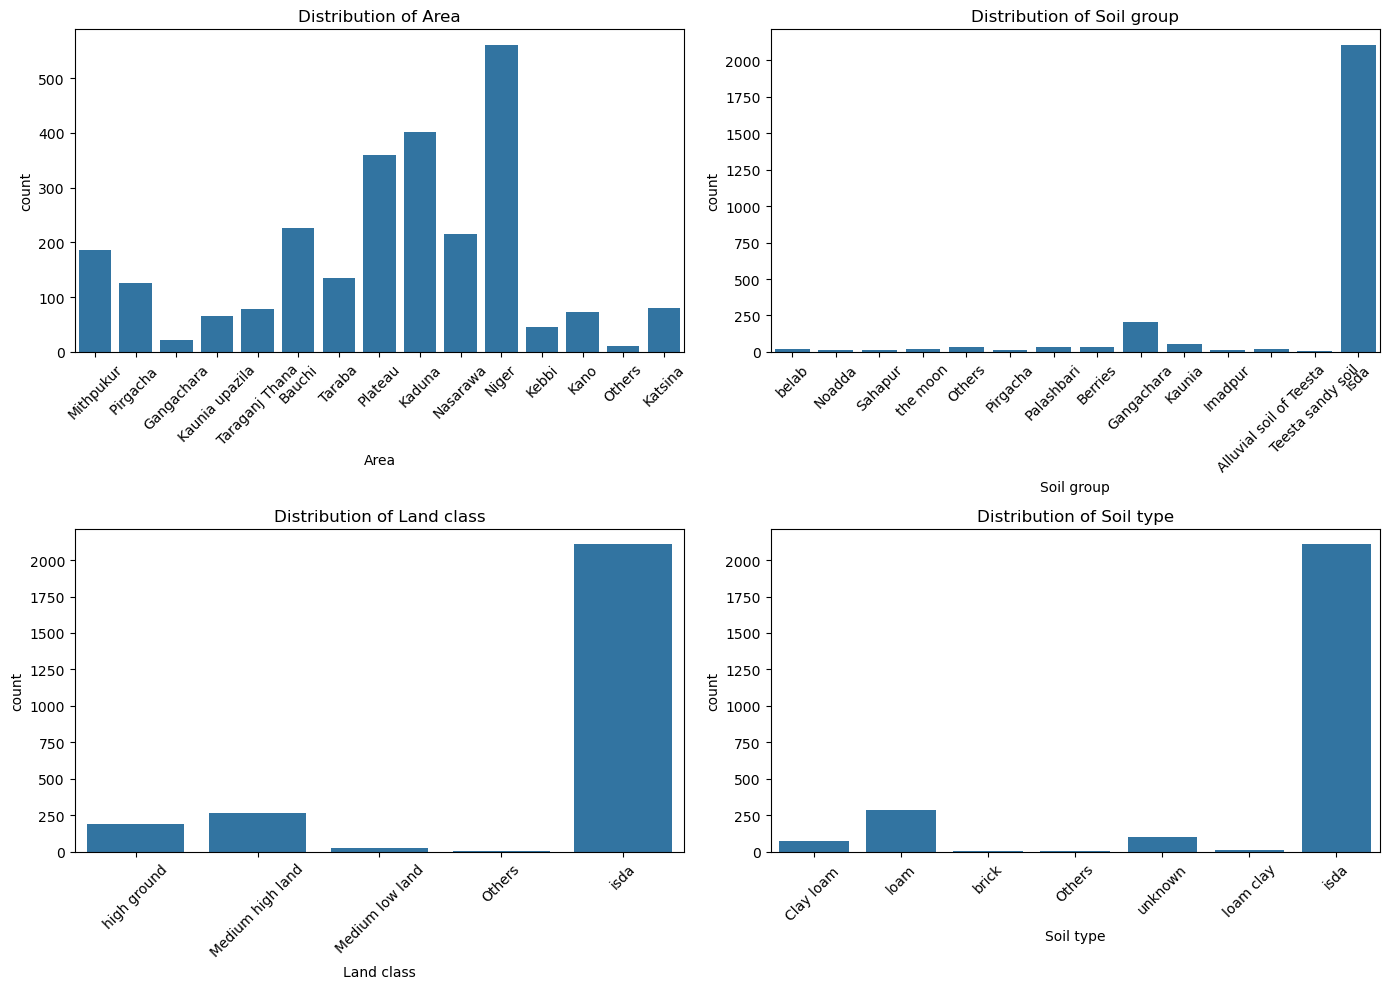

In [22]:
# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows and 2 columns

# Flatten the axes for easy indexing
axes = axes.flatten()

# Loop through the categorical features and plot
for i, feature in enumerate(categorical_features):
    sns.countplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2. Analyze Numerical Features

##### 1. Histograms: To visualize the distributions of numerical variables:

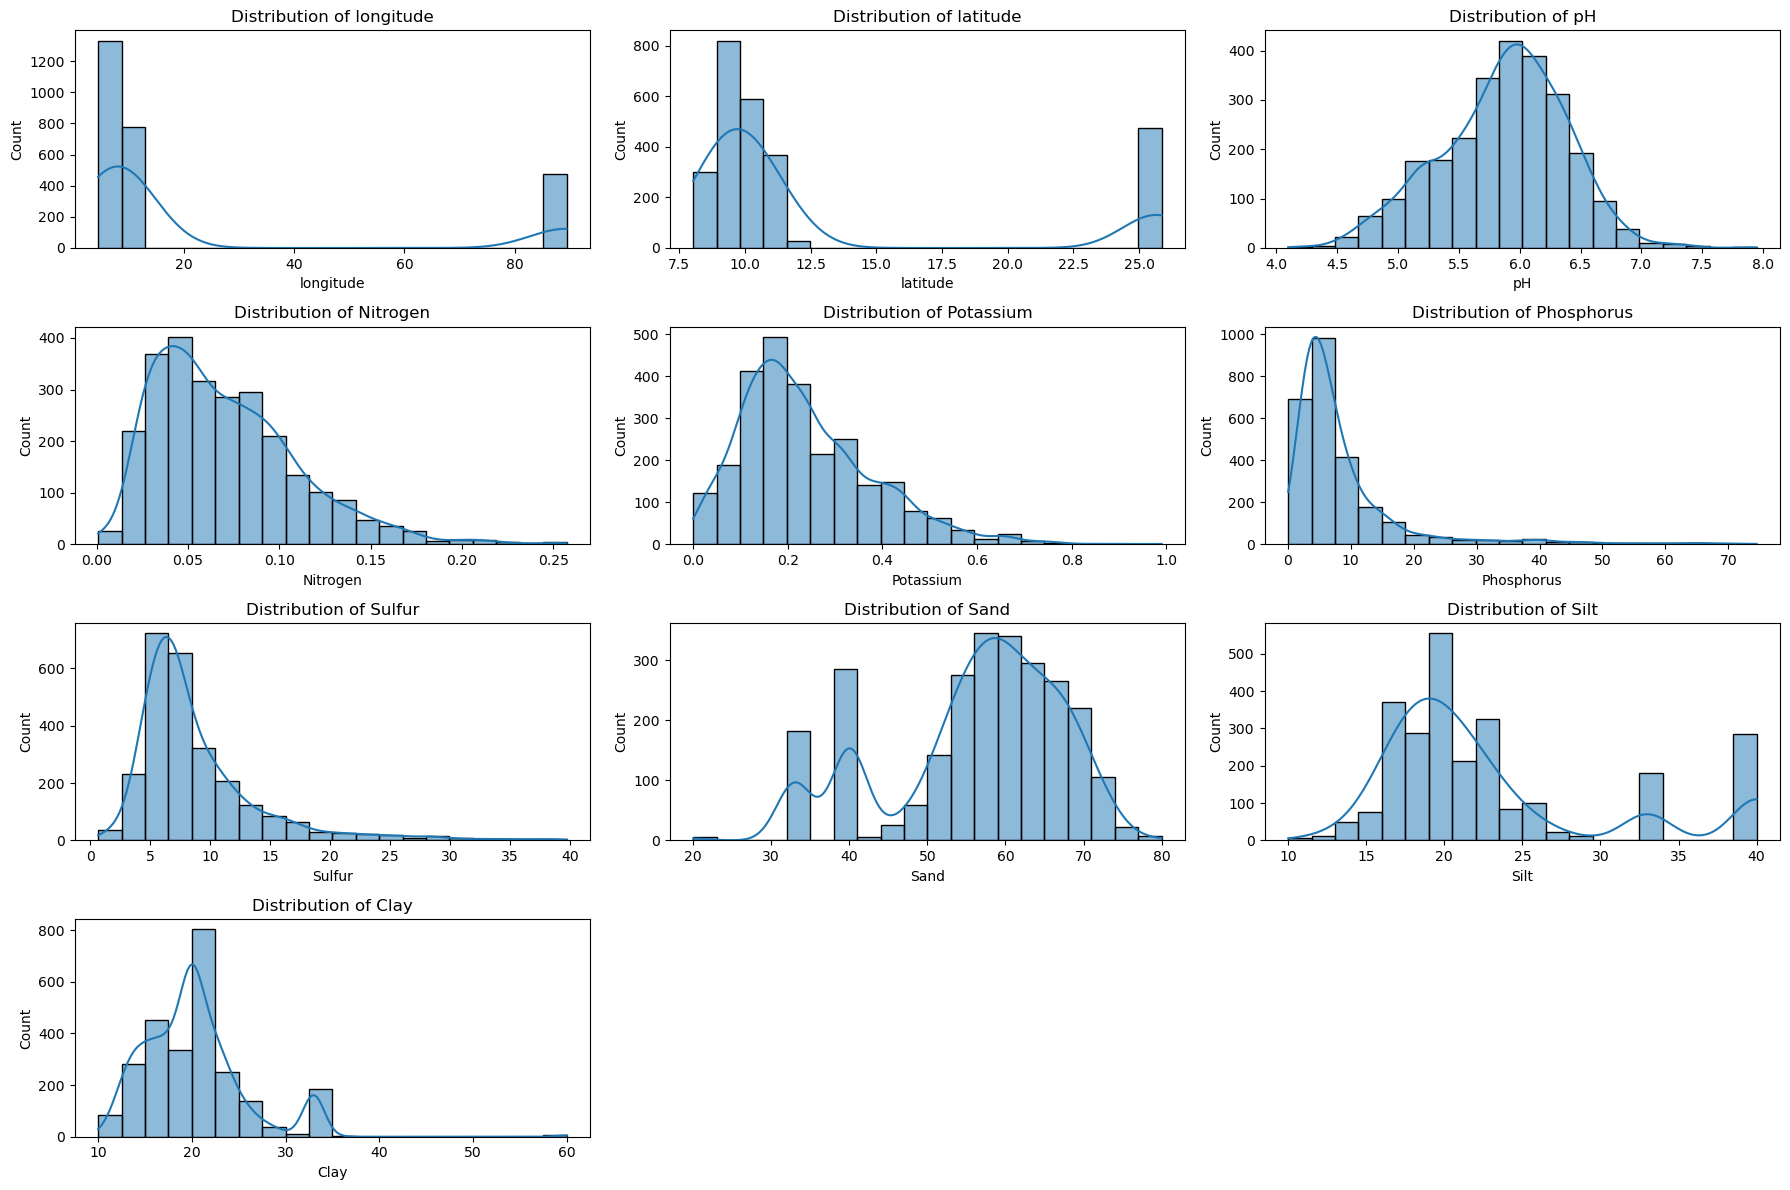

In [23]:
# Set up the number of rows and columns
num_features = len(numerical_features)
cols = 3  # Number of columns per row
rows = (num_features + cols - 1) // cols  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through numerical features and plot
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

# Remove unused subplots
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust Layout
plt.tight_layout()
plt.show()

##### 2. Check for Outliers

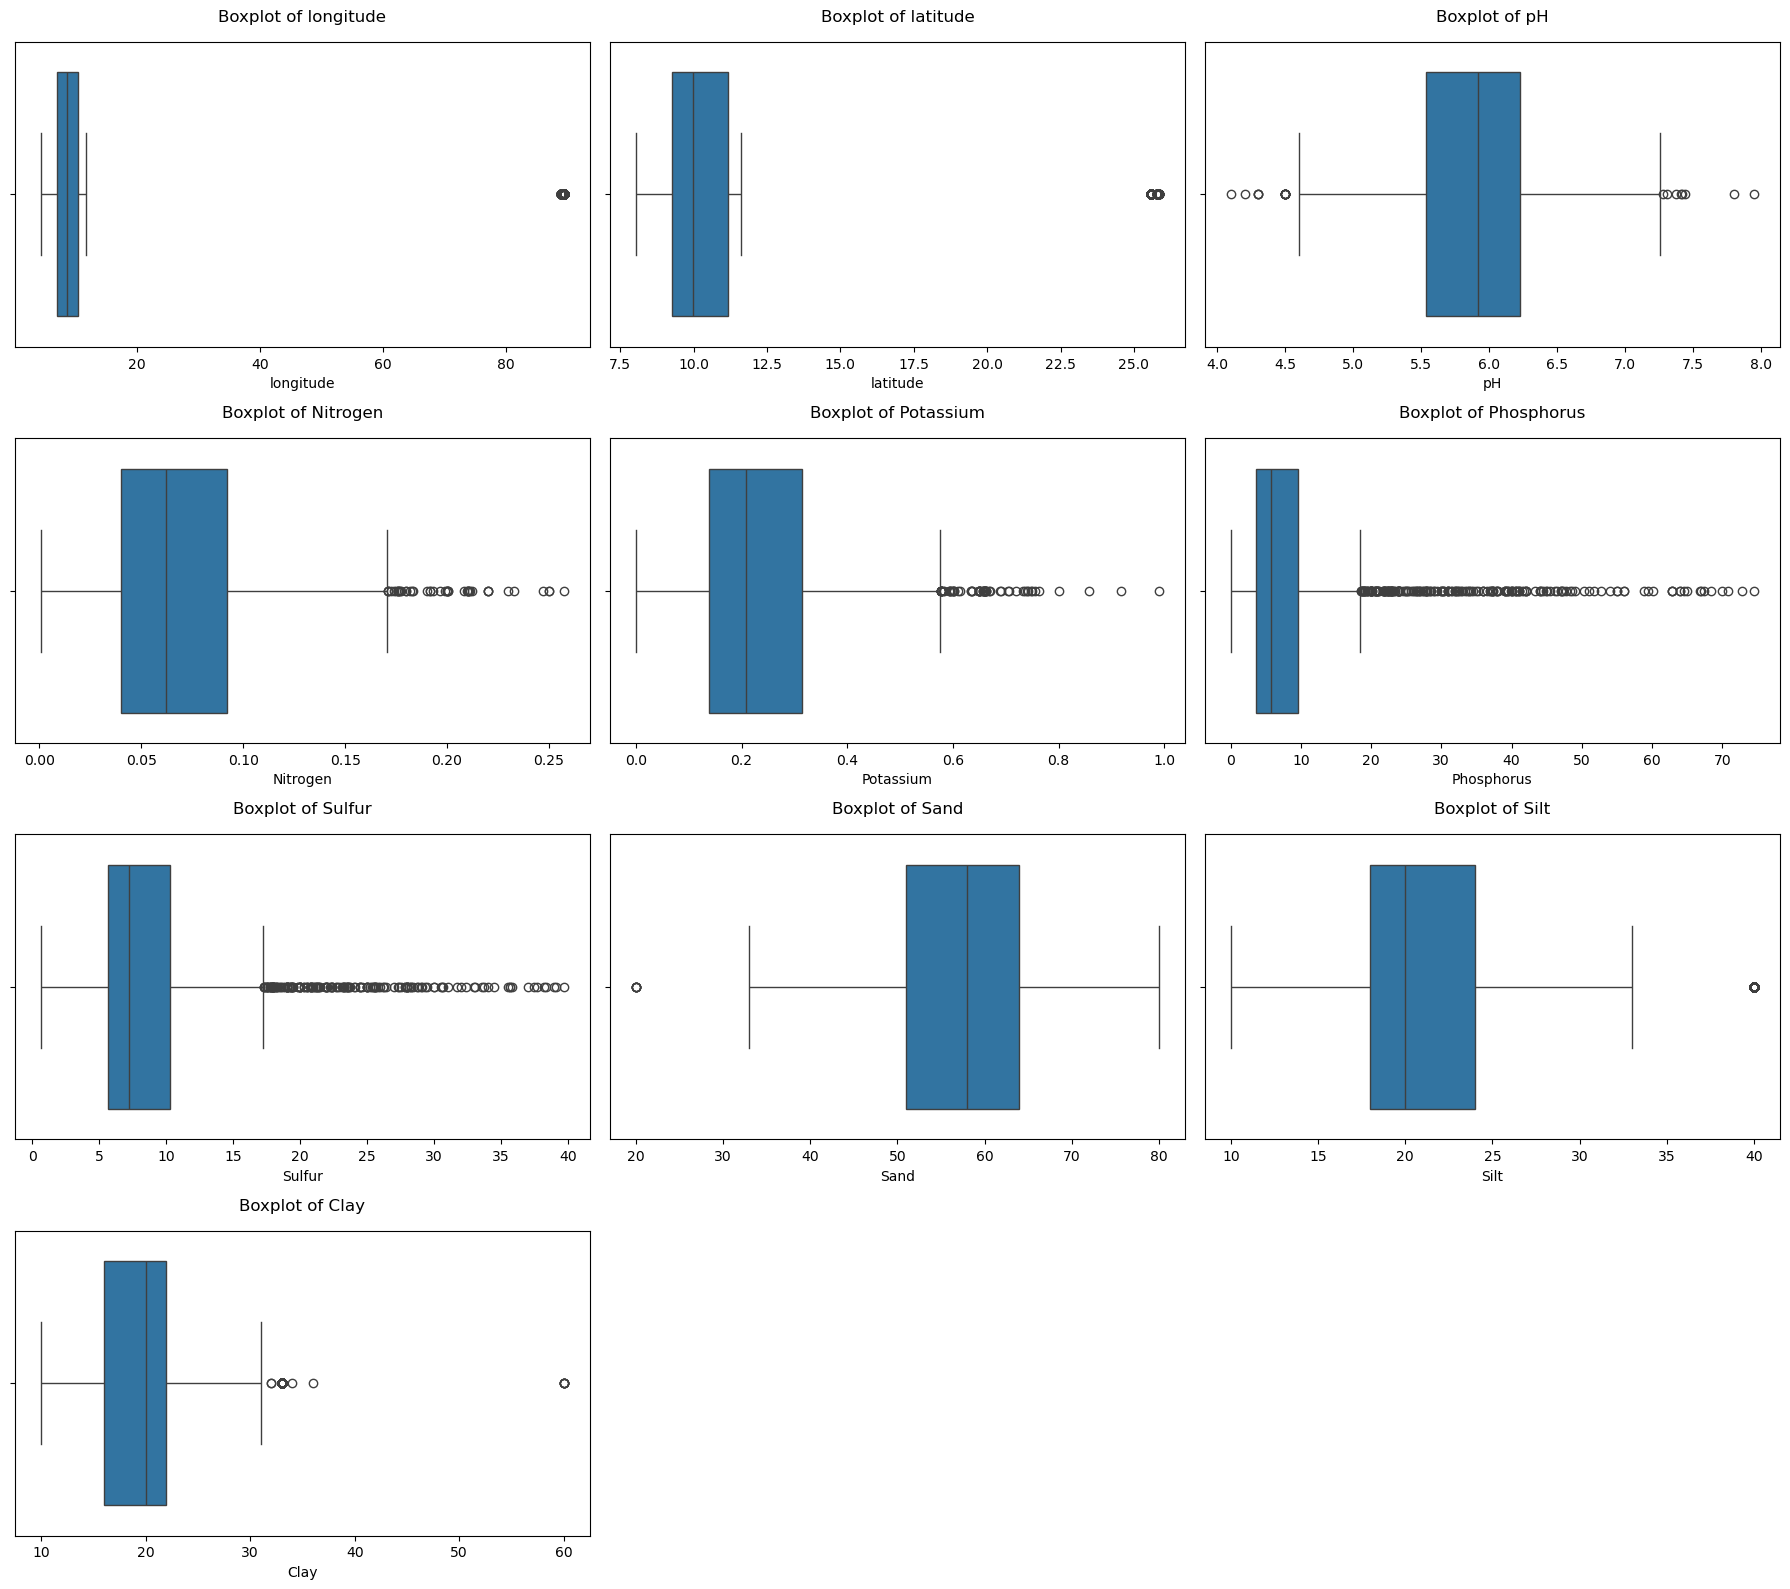

In [24]:
# Set the number of columns per row
cols = 3  # 3 plots in each row
num_features = len(numerical_features)
rows = (num_features + cols - 1) // cols  # Calculate the required number of rows dynamically

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))  # Adjust height for rows

# Flatten the axes for easier iteration
axes = axes.flatten()

# Loop through the numerical features and plot boxplots
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i])
    axes[i].set_title(f"Boxplot of {feature}", pad=15)  # Add padding for the title

# Remove unused subplots (if any)
for i in range(len(numerical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

##### 3. Display Range of Values in Numerical Features without Outliers

In [25]:
#df.drop(["longitude", "latitude"], axis=1).describe()

In [26]:
# Display the range for each numerical feature
print(f"\nRange of Values in Each Column (Numerical) without Outliers")
print("*" * 59, "\n")
for feature in numerical_features:
    min_val, max_val = range_without_outliers(df, feature)
    print(f"{feature}: Min: {min_val}, Max: {max_val}\n")


Range of Values in Each Column (Numerical) without Outliers
*********************************************************** 

longitude: Min: 4.4303, Max: 11.71565

latitude: Min: 8.03907, Max: 11.61652

pH: Min: 4.6, Max: 7.25826

Nitrogen: Min: 0.0008, Max: 0.170421

Potassium: Min: 0.0, Max: 0.5761871794871795

Phosphorus: Min: 0.06, Max: 18.4091

Sulfur: Min: 0.65, Max: 17.236

Sand: Min: 33.0, Max: 80.0

Silt: Min: 10.0, Max: 33.0

Clay: Min: 10.0, Max: 31.0



##### 4. Remove Outliers

In [27]:
# Dynamically apply the function to each numerical feature
for feature in numerical_features:
    df = remove_outliers(df, feature)

length_df_remove_outliers = len(df)
print(f"Length of Dataset After Removal of Ouliers")
print("*"* 42)
print(length_df_remove_outliers)

# Print the cleaned dataset
print("\nDataset after removing outliers:")
print("*"* 32, "\n")
df.describe().T

Length of Dataset After Removal of Ouliers
******************************************
2572

Dataset after removing outliers:
******************************** 



,count,mean,std,min,25%,50%,75%,max
longitude,2572.0,22.670623,31.343950,4.430300,6.968023,8.611715,10.416477,89.416700
latitude,2572.0,12.651232,6.162827,8.039070,9.250013,9.968350,11.147215,25.850000
pH,2572.0,5.872734,0.516360,4.100000,5.544477,5.918895,6.227370,7.945400
SOC,2572.0,0.999961,0.626380,0.100000,0.552021,0.803703,1.284992,4.480000
Nitrogen,2572.0,0.070295,0.039317,0.000800,0.040000,0.062087,0.092144,0.257264
Potassium,2572.0,0.238257,0.140553,0.000000,0.137771,0.209207,0.313721,0.990000
Phosphorus,2572.0,8.309131,8.348160,0.060000,3.657857,5.703735,9.403460,62.900000
Sulfur,2572.0,8.804159,5.227483,0.650000,5.660660,7.236340,10.217925,39.700000
Boron,2572.0,0.112374,0.130301,0.001611,0.024301,0.059704,0.153684,0.990000
Zinc,2572.0,1.189048,0.470255,0.080000,0.880000,1.145280,1.443835,4.000000


##### 5. Check for Skewness in Numerical Features

In [28]:
# df[numerical_features].head(3)

In [29]:
# Function to classify skewness
def classify_skewness(skewness):
    if abs(skewness) > 2:
        return "Highly Skewed", "Recommend Log Transformation (if positive) or Yeo-Johnson"
    elif abs(skewness) > 1:
        return "Moderately Skewed", "Recommend Yeo-Johnson Transformation"
    elif abs(skewness) > 0.5:
        return "Slightly Skewed", "Transformation optional"
    else:
        return "Symmetrical", "No transformation needed"

# Check skewness and provide recommendations
for feature in numerical_features:
    skewness = df[feature].skew()
    skewness_category, recommendation = classify_skewness(skewness)
    print(f"Skewness of '{feature}': {skewness:.4f}")
    print(f"  Skewness Category: {skewness_category}")
    print(f"  Recommendation: {recommendation}")
    print("-" * 100)

Skewness of 'longitude': 1.6487
  Skewness Category: Moderately Skewed
  Recommendation: Recommend Yeo-Johnson Transformation
----------------------------------------------------------------------------------------------------
Skewness of 'latitude': 1.5926
  Skewness Category: Moderately Skewed
  Recommendation: Recommend Yeo-Johnson Transformation
----------------------------------------------------------------------------------------------------
Skewness of 'pH': -0.2428
  Skewness Category: Symmetrical
  Recommendation: No transformation needed
----------------------------------------------------------------------------------------------------
Skewness of 'Nitrogen': 1.0149
  Skewness Category: Moderately Skewed
  Recommendation: Recommend Yeo-Johnson Transformation
----------------------------------------------------------------------------------------------------
Skewness of 'Potassium': 0.9851
  Skewness Category: Slightly Skewed
  Recommendation: Transformation optional
-------

#### 3. Analyze Relationships Between Features and Targets

##### 1. Categorical Features vs Targets

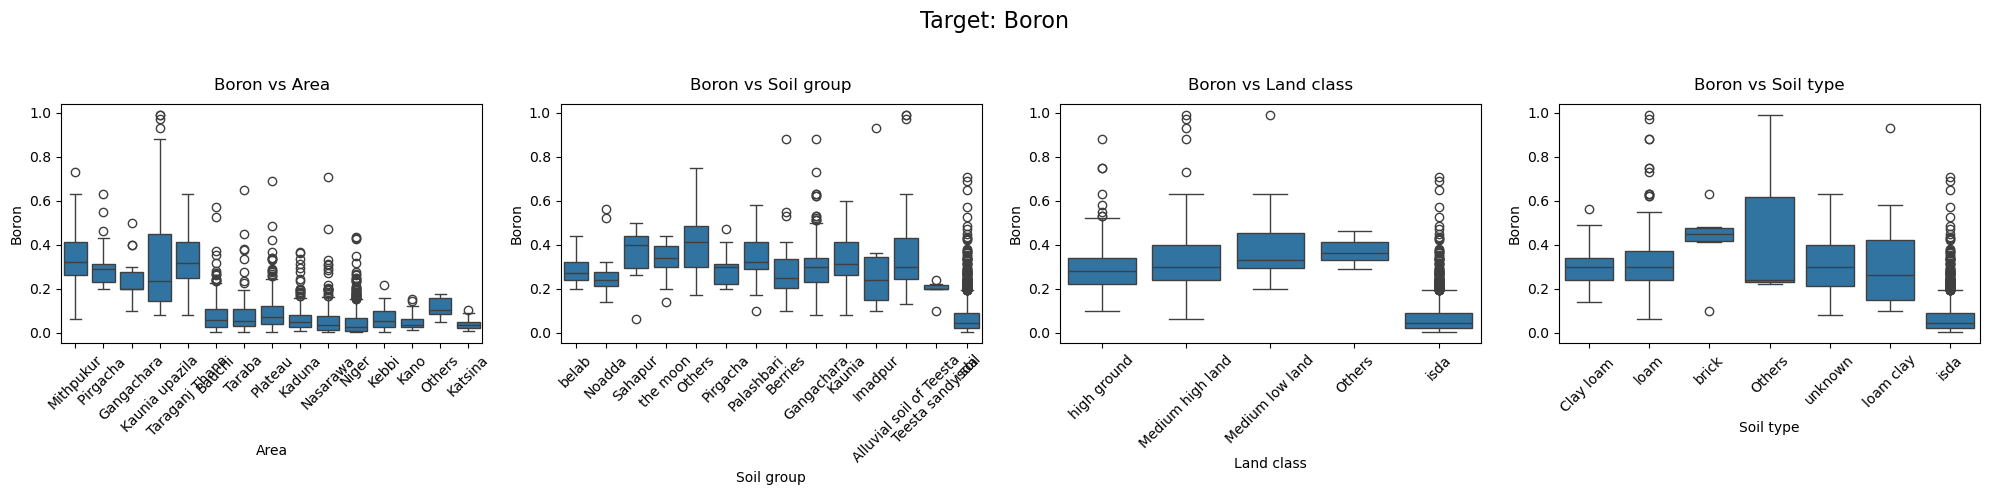

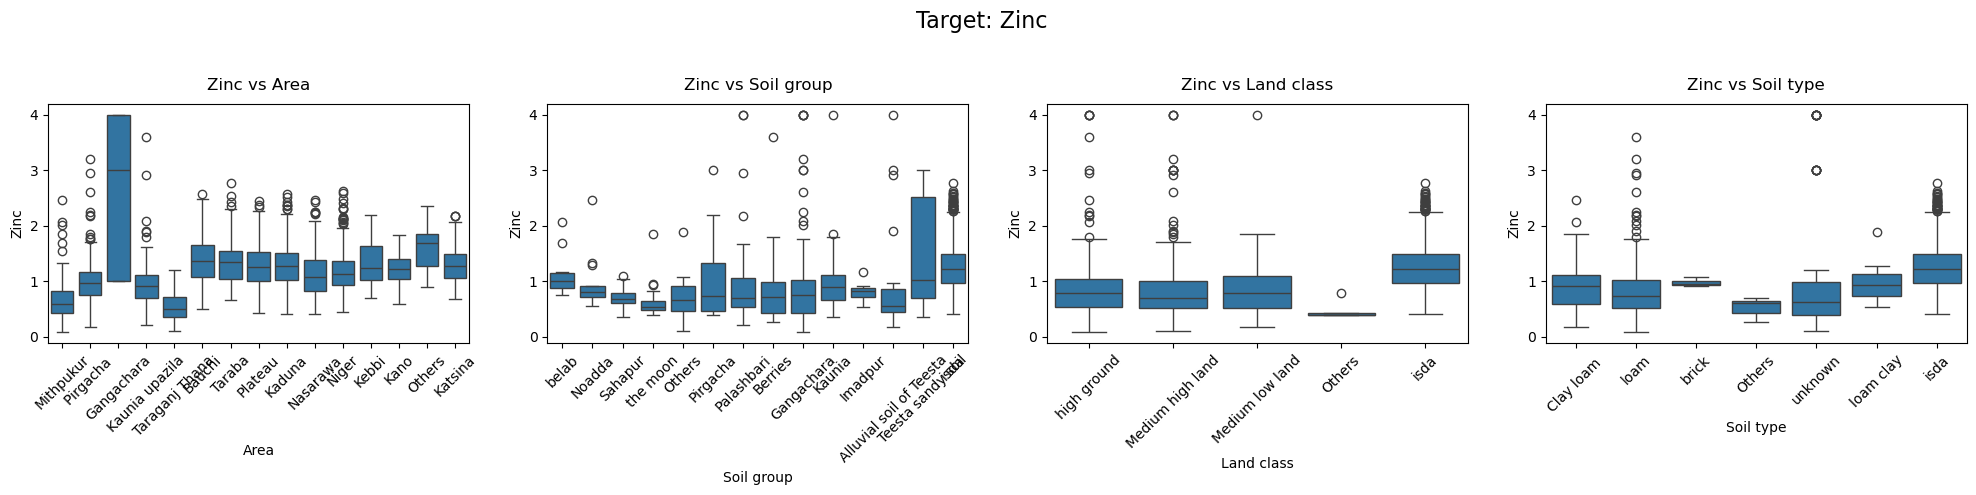

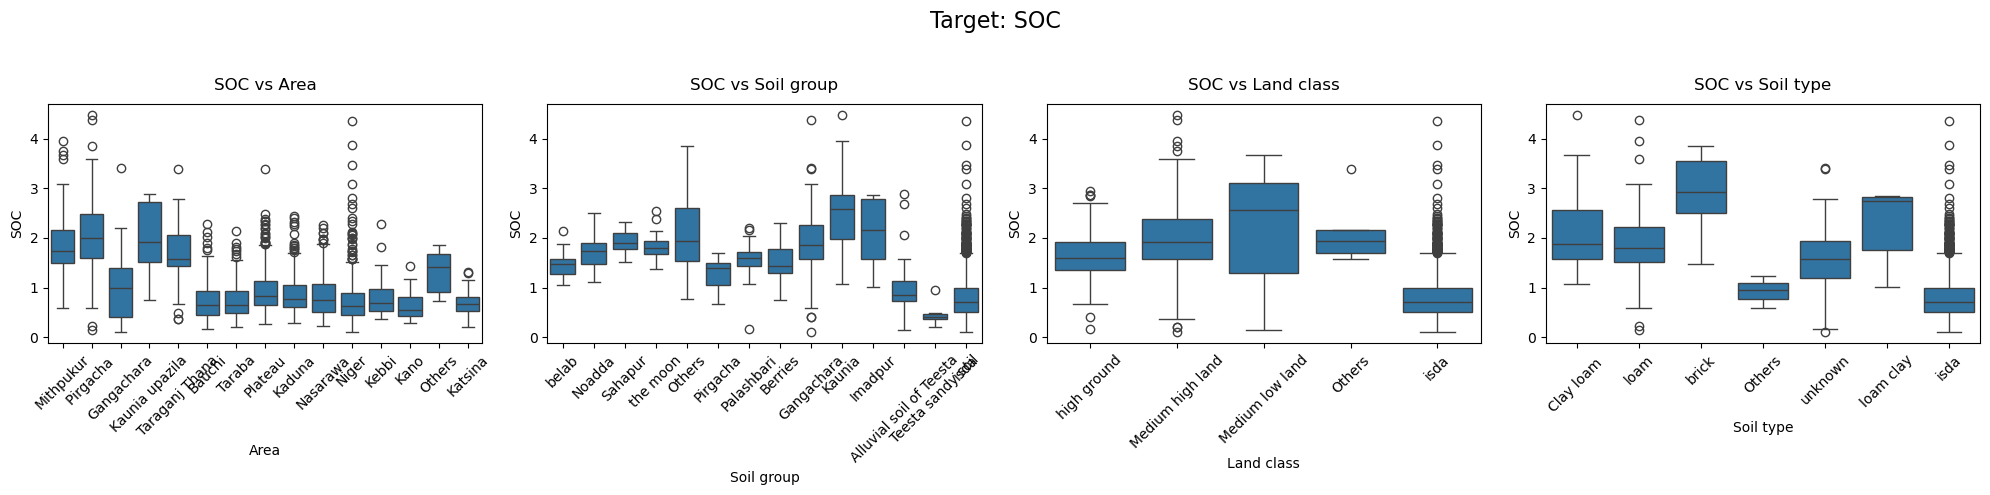

In [30]:
# Create subplots dynamically
for i, target in enumerate(targets):
    # One row, multiple columns
    fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 5))  
    
    for j, feature in enumerate(categorical_features):
        sns.boxplot(data=df, x=feature, y=target, ax=axes[j])
        axes[j].set_title(f"{target} vs {feature}", pad=10)
        axes[j].tick_params(axis='x', rotation=45)
    
    # Adjust layout for the current row
    plt.suptitle(f"Target: {target}", fontsize=16)
    # Add space for the suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()


In [31]:
# Step 1: Check unique categories for each feature
for feature in categorical_features:
    print(f"{feature}: {df[feature].nunique()} unique categories")

# Step 2: Filter categorical features with more than one unique category
valid_categorical_features = [feature for feature in categorical_features if df[feature].nunique() > 1]
print(f"Valid Category Features: {valid_categorical_features}")

# Step 3: Perform ANOVA for each target
anova_results_all_targets = {}

for target in targets:
    anova_results = {}  # To store results for the current target
    # print(f"\nPerforming ANOVA for target: {target}")
    
    for feature in valid_categorical_features:
        # Group target values by the categorical feature
        groups = [df[df[feature] == category][target].dropna() for category in df[feature].unique()]
        
        # Perform one-way ANOVA
        if len(groups) > 1:  # Ensure at least two groups exist
            f_stat, p_value = f_oneway(*groups)
            anova_results[feature] = {'F-Statistic': f_stat, 'p-value': p_value}
    
    # Convert results to a DataFrame
    anova_results_df = pd.DataFrame(anova_results).T
    anova_results_df['Significant'] = anova_results_df['p-value'] < 0.05
    
    # Store results for the current target
    anova_results_all_targets[target] = anova_results_df

# Step 4: Display all results after the loop
for target, results_df in anova_results_all_targets.items():
    print(f"\nANOVA Results for {target}:")
    print("*" * 25)
    print(results_df)

    # Optionally save to a CSV or Excel file
    # results_df.to_csv(f"anova_results_{target}.csv", index=True)
    # results_df.to_excel(f"anova_results_{target}.xlsx", index=True)

Area: 15 unique categories
Soil group: 14 unique categories
Land class: 5 unique categories
Soil type: 7 unique categories
Valid Category Features: ['Area', 'Soil group', 'Land class', 'Soil type']

ANOVA Results for Boron:
*************************
            F-Statistic  p-value  Significant
Area         254.714127      0.0         True
Soil group   264.282353      0.0         True
Land class   822.314748      0.0         True
Soil type    545.403584      0.0         True

ANOVA Results for Zinc:
*************************
            F-Statistic        p-value  Significant
Area          69.845633  4.364173e-168         True
Soil group    23.210276   2.203693e-53         True
Land class    66.833240   7.311137e-54         True
Soil type     46.046007   8.348724e-54         True

ANOVA Results for SOC:
*************************
            F-Statistic        p-value  Significant
Area         148.462548  2.424223e-317         True
Soil group   176.315886   0.000000e+00         True
Lan

In [32]:
# Filter features with more than one unique category
categorical_features = [feature for feature in categorical_features if df[feature].nunique() > 1]
print(f"Updated Categorical Features: {categorical_features}")

Updated Categorical Features: ['Area', 'Soil group', 'Land class', 'Soil type']


##### 2. Numerical Features vs Targets

a. Statistical Tests (ANOVA or t-tests)

In [33]:
# Perform statistical test for each target
statistical_results = {}
relevant_features = {}  # Dictionary to store relevant features for each target

for target in targets:
    # Separate features and target
    X = df[numerical_features]
    y = df[target]
    
    # Perform F-statistic test
    f_stat, p_values = f_regression(X, y)
    
    # Store results in a DataFrame
    result_df = pd.DataFrame({
        'Feature': numerical_features,
        'F-Statistic': f_stat,
        'p-value': p_values
    }).sort_values(by='p-value')
    
    # Save results for the current target
    statistical_results[target] = result_df
    
    # Filter features with p-value < 0.05
    relevant_features[target] = result_df[result_df['p-value'] < 0.05]['Feature'].tolist()

# Display statistical analysis for each target
for target, result_df in statistical_results.items():
    print(f"\nStatistical Analysis for Target: {target}")
    print("*" * 39)
    print(result_df)

# Dynamically Split Numerical Features
numFeatures_GroupA_Boron = relevant_features.get("Boron", [])
numFeatures_GroupA_Zinc = relevant_features.get("Zinc", [])
numFeatures_GroupA_SOC = relevant_features.get("SOC", [])

# Display relevant features for each target
print("\nRelevant Features for Each Target (p-value < 0.05):")
print("*" * 51)

if numFeatures_GroupA_Boron:
    print(f"Boron: {numFeatures_GroupA_Boron}")
else:
    print("Boron: No relevant features found (p-value >= 0.05)")

if numFeatures_GroupA_Zinc:
    print(f"Zinc: {numFeatures_GroupA_Zinc}")
else:
    print("Zinc: No relevant features found (p-value >= 0.05)")

if numFeatures_GroupA_SOC:
    print(f"SOC: {numFeatures_GroupA_SOC}")
else:
    print("SOC: No relevant features found (p-value >= 0.05)")


Statistical Analysis for Target: Boron
***************************************
      Feature  F-Statistic        p-value
0   longitude  3291.465453   0.000000e+00
1    latitude  3036.443264   0.000000e+00
7        Sand  1989.646806  2.618548e-322
8        Silt  1945.510075  7.004070e-317
6      Sulfur   821.738709  4.737444e-157
3    Nitrogen   773.856297  4.169238e-149
5  Phosphorus   757.394947  2.386280e-146
9        Clay   529.951432  8.968213e-107
2          pH   458.373959   1.037138e-93
4   Potassium    29.033818   7.758531e-08

Statistical Analysis for Target: Zinc
***************************************
      Feature  F-Statistic        p-value
4   Potassium   800.097829  1.786821e-153
0   longitude   248.113311   1.951225e-53
1    latitude   232.566615   2.456203e-50
8        Silt   215.887882   5.446344e-47
2          pH   150.691158   1.055910e-33
7        Sand    58.964317   2.265648e-14
3    Nitrogen    26.943673   2.258471e-07
6      Sulfur     9.543940   2.027567e-03
5

##### b. Handle Multicollinearity for Regression Models

In [34]:
# Flag for regression model
REGRESSION_MODEL = True

# Function to calculate VIF and handle multicollinearity
def handle_multicollinearity_vif(features, df, vif_threshold=15.0):
    X = df[features]
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Identify features with VIF above the threshold
    high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    
    # Dynamically create a second group without multicollinear features
    group_without_multicollinearity = [f for f in features if f not in high_vif_features]

    return group_without_multicollinearity, vif_data

# Check and dynamically create groups for each target
# Boron
if numFeatures_GroupA_Boron:
    print("\nHandling Multicollinearity for Boron:")
    print("*" * 38)
    numFeatures_GroupB_Boron, vif_boron = handle_multicollinearity_vif(numFeatures_GroupA_Boron, df)
    print(f"Group A (original): {numFeatures_GroupA_Boron}")
    print(f"Group B (adjusted): {numFeatures_GroupB_Boron}")
    if len(numFeatures_GroupB_Boron) < len(numFeatures_GroupA_Boron):  # Multicollinearity exists
        print("\nVIF Data for Boron:")
        print(vif_boron)
        if REGRESSION_MODEL:
            print("\nUse Group B for regression.")
        else:
            print("\nGroup B created but not needed for tree-based models.")
    else:
        print("\nNo multicollinearity found.")
        if REGRESSION_MODEL:
            print("\nUse Group A for regression.")
        else:
            print("\nUse Group A for tree-based models.")

# Zinc
if numFeatures_GroupA_Zinc:
    print("\nHandling Multicollinearity for Zinc:")
    print("*" * 36)
    numFeatures_GroupB_Zinc, vif_zinc = handle_multicollinearity_vif(numFeatures_GroupA_Zinc, df)
    print(f"Group A (original): {numFeatures_GroupA_Zinc}")
    print(f"Group B (adjusted): {numFeatures_GroupB_Zinc}")
    if len(numFeatures_GroupB_Zinc) < len(numFeatures_GroupA_Zinc):  # Multicollinearity exists
        print("\nVIF Data for Zinc:")
        print(vif_zinc)
        if REGRESSION_MODEL:
            print("\nUse Group B for regression.")
        else:
            print("\nGroup B created but not needed for tree-based models.")
    else:
        print("\nNo multicollinearity found.")
        if REGRESSION_MODEL:
            print("\nUse Group A for regression.")
        else:
            print("\nUse Group A for tree-based models.")

# SOC
if numFeatures_GroupA_SOC:
    print("\nHandling Multicollinearity for SOC:")
    print("*" * 35)
    numFeatures_GroupB_SOC, vif_soc = handle_multicollinearity_vif(numFeatures_GroupA_SOC, df)
    print(f"Group A (original): {numFeatures_GroupA_SOC}")
    print(f"Group B (adjusted): {numFeatures_GroupB_SOC}")
    if len(numFeatures_GroupB_SOC) < len(numFeatures_GroupA_SOC):  # Multicollinearity exists
        print("\nVIF Data for SOC:")
        print(vif_soc)
        if REGRESSION_MODEL:
            print("\nUse Group B for regression.")
        else:
            print("\nGroup B created but not needed for tree-based models.")
    else:
        print("\nNo multicollinearity found.")
        if REGRESSION_MODEL:
            print("\nUse Group A for regression.")
        else:
            print("\nUse Group A for tree-based models.")


Handling Multicollinearity for Boron:
**************************************
Group A (original): ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium']
Group B (adjusted): ['Sulfur', 'Nitrogen', 'Phosphorus', 'Potassium']

VIF Data for Boron:
      Feature         VIF
0   longitude   69.872501
1    latitude  224.665139
2        Sand  115.944801
3        Silt   52.903782
4      Sulfur    6.042190
5    Nitrogen    6.086459
6  Phosphorus    3.027922
7        Clay   26.364888
8          pH  203.631127
9   Potassium    5.358789

Use Group B for regression.

Handling Multicollinearity for Zinc:
************************************
Group A (original): ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus']
Group B (adjusted): ['Potassium', 'Nitrogen', 'Sulfur', 'Phosphorus']

VIF Data for Zinc:
      Feature         VIF
0   Potassium    5.357295
1   longitude   65.338053
2    latitude  202.736100
3    

#### Defin Models

In [35]:
models = {
    'LinearRegression': {
        'model': MultiOutputRegressor(LinearRegression()),
        'type': 'regression',
        'params': {}  # No significant hyperparameters for Linear Regression
    },
    'Lasso': {
        'model': MultiOutputRegressor(Lasso()),
        'type': 'regression',
        'params': {"model__estimator__alpha": MODEL_ESTIMATOR_ALPHA}
    },
    'DecisionTree': {
        'model': MultiOutputRegressor(DecisionTreeRegressor()),
        'type': 'tree',
        'params': {
            'model__estimator__max_depth': MODEL_ESTIMATOR_DEPTH,
            'model__estimator__min_samples_leaf': MIN_SAMPLE_LEAF,
        }
    },
    'RandomForest': {
        'model': MultiOutputRegressor(RandomForestRegressor(random_state=RANDOM_STATE)),
        'type': 'tree',
        'params': {
            'model__estimator__n_estimators': MODEL_ESTIMATOR_N_ESTIMATORS_RF,
            'model__estimator__max_depth': MODEL_ESTIMATOR_MAX_DEPTH,
            # 'model__estimator__min_samples_leaf': MIN_SAMPLE_LEAF,
        }
    },
    'AdaBoost': {
        'model': MultiOutputRegressor(AdaBoostRegressor(random_state=RANDOM_STATE)),
        'type': 'tree',
        'params': {
            'model__estimator__n_estimators': MODEL_ESTIMATOR_N_ESTIMATORS_ADA,
        }
    },
    'Bagging': {
        'model': MultiOutputRegressor(BaggingRegressor(random_state=RANDOM_STATE)),
        'type': 'tree',
        'params': {
            'model__estimator__n_estimators': MODEL_ESTIMATOR_N_ESTIMATORS_BAGGING,
        }
    },
    'KNeighbors': {
        'model': MultiOutputRegressor(KNeighborsRegressor()),
        'type': 'tree',
        'params': {
            'model__estimator__n_neighbors': MODEL_ESTIMATOR_N_NEIGHBORS,
        }
    },
    'SVR': {
        'model': MultiOutputRegressor(SVR()),
        'type': 'regression',
        'params': {
            'model__estimator__C': MODEL_ESTIMATOR_C_SVR,
        }
    },
    # 'XGB': {
    #     'model': MultiOutputRegressor(XGBRegressor(random_state=0)),
    #     'type': 'tree',
    #     'params': {
    #         'model__estimator__n_estimators': MODEL_ESTIMATOR_N_ESTIMATORS_RF,
    #         'model__estimator__max_depth': MODEL_ESTIMATOR_MAX_DEPTH,
    #         'model__estimator__learning_rate': MODEL_ESTIMATOR_ALPHA,
    #     }
    # },
    'CatBoost': {
        'model': MultiOutputRegressor(CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)),
        'type': 'tree',
        'params': {
            'model__estimator__depth': MODEL_ESTIMATOR_DEPTH,
            'model__estimator__learning_rate': CATBOOST_LEARNING_RATE,
        }
    }
}

#### Define Feature Sets For Numerical Variables

In [36]:
# Feature sets for each group

feature_sets = {
    'GroupA': {
        'Boron': numFeatures_GroupA_Boron + categorical_features,  # Group A for Boron
        'Zinc': numFeatures_GroupA_Zinc + categorical_features,    # Group A for Zinc
        'SOC': numFeatures_GroupA_SOC + categorical_features       # Group A for SOC
    },
    'GroupB': {
        'Boron': numFeatures_GroupB_Boron + categorical_features,  # Group B for Boron
        'Zinc': numFeatures_GroupB_Zinc + categorical_features,    # Group B for Zinc
        'SOC': numFeatures_GroupB_SOC + categorical_features       # Group B for SOC
    }
}

#### Dataset split

In [37]:
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['Area', 'Soil group', 'Land class', 'Soil type']
Numerical Features: ['longitude', 'latitude', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


In [38]:
# X = df[numerical_features + categorical_features]  # Full feature set
y = df[targets]  # Target variables

In [39]:
print(f"X Columns: {X.columns}")
print(f"y Columns: {y.columns}")

X Columns: Index(['longitude', 'latitude', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus',
       'Sulfur', 'Sand', 'Silt', 'Clay'],
      dtype='object')
y Columns: Index(['Boron', 'Zinc', 'SOC'], dtype='object')


#### Apply Transformations To Numerical Features

In [40]:
# transformed_num_features, num_transformation_report = transform_features_for_skewness(numerical_features, df)
# num_transformation_report

In [41]:
# transformed_num_features.head(3)

In [42]:
# # Update Numerical Features in DataFrameabs
# df[numerical_features] = transformed_num_features

In [43]:
# # Again Check skewness and provide recommendations
# for num_feature in numerical_features:
#     skewness = df[num_feature].skew()
#     skewness_category, recommendation = classify_skewness(skewness)
#     print(f"Skewness of '{num_feature}': {skewness:.4f}")
#     print(f"  Skewness Category: {skewness_category}")
#     print(f"  Recommendation: {recommendation}")
#     print("-" * 100)

#### Apply Transformations To Targets 

In [44]:
# specific_transformations = {"Boron": "boxcox"}
transformed_targets, target_transformation_report = transform_targets(y, skewness_threshold=0.75, specific_transformations=None)

In [45]:
target_transformation_report

,Target,Original Skewness,Final Skewness,Selected Transformation,Lambda (if applicable)
0,Boron,2.075309,0.411982,yeo_johnson,None
1,Zinc,1.106170,-0.002253,yeo_johnson,None
2,SOC,1.518180,0.092546,yeo_johnson,None


In [46]:
transformed_targets.head(3)

,Boron,Zinc,SOC
0,1.426867,-0.672824,0.755784
1,1.389984,-0.966597,1.005464
2,1.461274,-0.445569,0.451297
3,1.493388,-0.323972,1.050063
4,1.551403,-0.228943,0.468088


In [47]:
### Update Targets
df[targets] = transformed_targets
y = df[targets]
y.head(3)

,Boron,Zinc,SOC
0,1.426867,-0.672824,0.755784
1,1.389984,-0.966597,1.005464
2,1.461274,-0.445569,0.451297


In [48]:
# Again Check skewness and provide recommendations
for target in targets:
    skewness = df[target].skew()
    skewness_category, recommendation = classify_skewness(skewness)
    print(f"Skewness of '{target}': {skewness:.4f}")
    print(f"  Skewness Category: {skewness_category}")
    print(f"  Recommendation: {recommendation}")
    print("-" * 100)

Skewness of 'Boron': 0.4120
  Skewness Category: Symmetrical
  Recommendation: No transformation needed
----------------------------------------------------------------------------------------------------
Skewness of 'Zinc': -0.0023
  Skewness Category: Symmetrical
  Recommendation: No transformation needed
----------------------------------------------------------------------------------------------------
Skewness of 'SOC': 0.0925
  Skewness Category: Symmetrical
  Recommendation: No transformation needed
----------------------------------------------------------------------------------------------------


#### Split data into train, Val and test sets

In [49]:
X = df[numerical_features + categorical_features]  # Full feature set

In [50]:
# First split: Train + Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - TRAIN_SIZE), random_state=RANDOM_STATE)

# Second split: Validation + Test from Temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(TEST_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=RANDOM_STATE)

print(f"Training Set: {X_train.shape}, Validation Set: {X_val.shape}, Test Set: {X_test.shape}")

Training Set: (1800, 14), Validation Set: (257, 14), Test Set: (515, 14)


In [51]:
# Define preprocessing steps
numerical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=NUM_SIMPLE_IMPUTER)),
        # ("skewness", SkewnessTransformer()),  # Apply skewness transformations
        ("scaler", StandardScaler()),  # Scale features after transformation,
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=CAT_SIMPLE_IMPUTER)),
        ("onehot", OneHotEncoder(handle_unknown=ONE_HOT_ENCODER_HANDLE_UNKNOWN)),
    ]
)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numerical_transformer, numerical_features),
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# pipeline.named_steps['preprocessor'].transformers_[0][1].named_steps['skewness'].skewness_report


In [52]:
print(f"Categorical Features: {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features: ['Area', 'Soil group', 'Land class', 'Soil type']
Numerical Features: ['longitude', 'latitude', 'pH', 'Nitrogen', 'Potassium', 'Phosphorus', 'Sulfur', 'Sand', 'Silt', 'Clay']


#### Train Models with MLFlow

In [53]:
# MLflow experiment setup
URI = "http://127.0.0.1:5000"
mlflow.set_experiment("Model_Experimentation")
# mlflow.set_tracking_uri(URI)

# Dictionaries to track the best model and score for each target
best_models = {}
best_r2_scores = {}
best_model_paths = {}
best_features = {}

counter = 1

# Iterate over models and feature sets
for model_name, model_info in models.items():
    base_model = model_info['model']
    model_type = model_info['type']
    hyperparameters = model_info.get('params', {})  # Get hyperparameters for the model
    
    # Select feature set based on model type
    feature_set_key = 'GroupB' if model_type == 'regression' else 'GroupA'
    feature_set = feature_sets[feature_set_key]
    
    print(f"\nTraining {model_name} (Type: {model_type}) using {feature_set_key}... | {counter}")
    print("*" * 60)
    
    # Update preprocessor dynamically
    for target, features in feature_set.items():
        # print(f"Targe: {target}")
        # print(f"Features: {features}")

        # Initialize or retrieve the best score and model for this target
        if target not in best_r2_scores:
            best_r2_scores[target] = -np.inf
            best_models[target] = None
            best_model_paths[target] = None
            best_features[target] = None  # Initialize for storing features
        
        # Preprocessing and pipeline setup
        selected_numerical_features = [f for f in features if f in numerical_features]
        selected_categorical_features = [f for f in features if f in categorical_features]
        # selected_categorical_features = categorical_features

        # print(f"Selected Categorical Features: {selected_categorical_features}")
        # print(f"Selected Numerical Features: {selected_numerical_features}")
        
        # Update preprocessor for the selected features
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", numerical_transformer, selected_numerical_features),
                ("cat", categorical_transformer, selected_categorical_features),
            ]
        )
    
        # Combine preprocessor and model into a pipeline
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("model", base_model)
        ])

        # Prepare feature subsets and targets
        X_train_features = X_train[features]
        X_val_features = X_val[features]
        X_test_features = X_test[features]
        
        y_train_target_values = y_train[target]
        y_val_target_values = y_val[target]
        y_test_target_values = y_test[target]

        # Ensure y values are 2D
        # Use double brackets to extract as DataFrame
        y_train_target_values = y_train[[target]]
        y_val_target_values = y_val[[target]]
        y_test_target_values = y_test[[target]]
    
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=hyperparameters,
            scoring=GRIDSEARCHCV_SCORING,
            cv=CV
        )
    
        with mlflow.start_run(run_name=f"{model_name}_{target}_{feature_set_key}"):
            # Fit GridSearchCV
            grid_search.fit(X_train_features, y_train_target_values)
            best_pipeline = grid_search.best_estimator_

            # Evaluate on validation set
            val_predictions = best_pipeline.predict(X_val_features)
            val_r2 = r2_score(y_val_target_values, val_predictions)
        
            # Log parameters, metrics, and model
            logged_params = {
                "model_name": model_name,
                "target": target,
                "feature_set": feature_set_key,
                "features": features,
                **grid_search.best_params_,
            }
            
            # Log parameters
            for param_name, param_value in logged_params.items():
                mlflow.log_param(param_name, param_value)
        
            # Print logged parameters
            print(f"Parameters for {model_name} and Target {target}:")
            for param_name, param_value in logged_params.items():
                print(f"    {param_name}: {param_value}")

            # Log validation R²
            mlflow.log_metric("val_r2", val_r2)
        
            # Evaluate on test set
            test_predictions = best_pipeline.predict(X_test_features)
            mae = mean_absolute_error(y_test_target_values, test_predictions)
            mse = mean_squared_error(y_test_target_values, test_predictions)
            r2 = r2_score(y_test_target_values, test_predictions)
        
            # Log test set metrics
            mlflow.log_metric("mae", mae)
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("r2", r2)

            # Save the best model for this target based on validation R² score
            # if val_r2 > best_r2_scores[target]:
            if r2 > best_r2_scores[target]:
                # best_r2_scores[target] = val_r2
                best_r2_scores[target] = r2
                best_models[target] = best_pipeline
                best_features[target] = features  # Update best features
                best_model_name = f"Maz_{model_name}_{target}_{feature_set_key}"
                
                # best_model_path = Path(
                #     f"{MODEL_SAVE_PATH}{best_model_name}_r2_{round(val_r2, 4)}_dateaset_{DATASET_VERSION}.pkl"
                # )
                best_model_path = Path(
                    f"{MODEL_SAVE_PATH}{best_model_name}_r2_{round(r2, 4)}_dateaset_{DATASET_VERSION}.pkl"
                )
                best_model_paths[target] = best_model_path
                joblib.dump(best_pipeline, best_model_path)

                # Log the model in MLflow
                input_example = pd.DataFrame([X_test.iloc[0].values], columns=X_test.columns)
                mlflow.sklearn.log_model(
                    best_pipeline,
                    artifact_path=f"Maz_{model_name}_{target}_{feature_set_key}",
                    input_example=input_example
                )
                # print(f"New Best Model Found for {target}: {best_model_name} with Validation R²: {r2:.4f}")
                print(f"New Best Model Found for {target}: {best_model_name} with Test R²: {r2:.4f}")
                print(f"Best model for {target} saved to {best_model_path}")

    # Update Counter
    counter += 1

2024/12/27 15:17:32 INFO mlflow.tracking.fluent: Experiment with name 'Model_Experimentation' does not exist. Creating a new experiment.



Training LinearRegression (Type: regression) using GroupB... | 1
************************************************************
Parameters for LinearRegression and Target Boron:
    model_name: LinearRegression
    target: Boron
    feature_set: GroupB
    features: ['Sulfur', 'Nitrogen', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']


New Best Model Found for Boron: Maz_LinearRegression_Boron_GroupB with Test R²: 0.6698
Best model for Boron saved to checkpoints\trained_multiple_models\Maz_LinearRegression_Boron_GroupB_r2_0.6698_dateaset_v3.pkl
Parameters for LinearRegression and Target Zinc:
    model_name: LinearRegression
    target: Zinc
    feature_set: GroupB
    features: ['Potassium', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']


New Best Model Found for Zinc: Maz_LinearRegression_Zinc_GroupB with Test R²: 0.4626
Best model for Zinc saved to checkpoints\trained_multiple_models\Maz_LinearRegression_Zinc_GroupB_r2_0.4626_dateaset_v3.pkl
Parameters for LinearRegression and Target SOC:
    model_name: LinearRegression
    target: SOC
    feature_set: GroupB
    features: ['Nitrogen', 'Sulfur', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']


New Best Model Found for SOC: Maz_LinearRegression_SOC_GroupB with Test R²: 0.7973
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_LinearRegression_SOC_GroupB_r2_0.7973_dateaset_v3.pkl

Training Lasso (Type: regression) using GroupB... | 2
************************************************************
Parameters for Lasso and Target Boron:
    model_name: Lasso
    target: Boron
    feature_set: GroupB
    features: ['Sulfur', 'Nitrogen', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__alpha: 0.001
Parameters for Lasso and Target Zinc:
    model_name: Lasso
    target: Zinc
    feature_set: GroupB
    features: ['Potassium', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__alpha: 0.0001


New Best Model Found for Zinc: Maz_Lasso_Zinc_GroupB with Test R²: 0.4656
Best model for Zinc saved to checkpoints\trained_multiple_models\Maz_Lasso_Zinc_GroupB_r2_0.4656_dateaset_v3.pkl
Parameters for Lasso and Target SOC:
    model_name: Lasso
    target: SOC
    feature_set: GroupB
    features: ['Nitrogen', 'Sulfur', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__alpha: 0.0001


New Best Model Found for SOC: Maz_Lasso_SOC_GroupB with Test R²: 0.7993
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_Lasso_SOC_GroupB_r2_0.7993_dateaset_v3.pkl

Training DecisionTree (Type: tree) using GroupA... | 3
************************************************************
Parameters for DecisionTree and Target Boron:
    model_name: DecisionTree
    target: Boron
    feature_set: GroupA
    features: ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 4
    model__estimator__min_samples_leaf: 7


New Best Model Found for Boron: Maz_DecisionTree_Boron_GroupA with Test R²: 0.6883
Best model for Boron saved to checkpoints\trained_multiple_models\Maz_DecisionTree_Boron_GroupA_r2_0.6883_dateaset_v3.pkl
Parameters for DecisionTree and Target Zinc:
    model_name: DecisionTree
    target: Zinc
    feature_set: GroupA
    features: ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 4
    model__estimator__min_samples_leaf: 3
Parameters for DecisionTree and Target SOC:
    model_name: DecisionTree
    target: SOC
    feature_set: GroupA
    features: ['Nitrogen', 'longitude', 'Sand', 'latitude', 'Silt', 'Sulfur', 'pH', 'Clay', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 6
    model__estimator__min_samples_leaf: 5


New Best Model Found for SOC: Maz_DecisionTree_SOC_GroupA with Test R²: 0.8025
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_DecisionTree_SOC_GroupA_r2_0.8025_dateaset_v3.pkl

Training RandomForest (Type: tree) using GroupA... | 4
************************************************************
Parameters for RandomForest and Target Boron:
    model_name: RandomForest
    target: Boron
    feature_set: GroupA
    features: ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 15
    model__estimator__n_estimators: 200


New Best Model Found for Boron: Maz_RandomForest_Boron_GroupA with Test R²: 0.7392
Best model for Boron saved to checkpoints\trained_multiple_models\Maz_RandomForest_Boron_GroupA_r2_0.7392_dateaset_v3.pkl
Parameters for RandomForest and Target Zinc:
    model_name: RandomForest
    target: Zinc
    feature_set: GroupA
    features: ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 10
    model__estimator__n_estimators: 100


New Best Model Found for Zinc: Maz_RandomForest_Zinc_GroupA with Test R²: 0.5585
Best model for Zinc saved to checkpoints\trained_multiple_models\Maz_RandomForest_Zinc_GroupA_r2_0.5585_dateaset_v3.pkl
Parameters for RandomForest and Target SOC:
    model_name: RandomForest
    target: SOC
    feature_set: GroupA
    features: ['Nitrogen', 'longitude', 'Sand', 'latitude', 'Silt', 'Sulfur', 'pH', 'Clay', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__max_depth: 5
    model__estimator__n_estimators: 100


New Best Model Found for SOC: Maz_RandomForest_SOC_GroupA with Test R²: 0.8259
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_RandomForest_SOC_GroupA_r2_0.8259_dateaset_v3.pkl

Training AdaBoost (Type: tree) using GroupA... | 5
************************************************************
Parameters for AdaBoost and Target Boron:
    model_name: AdaBoost
    target: Boron
    feature_set: GroupA
    features: ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__n_estimators: 50
Parameters for AdaBoost and Target Zinc:
    model_name: AdaBoost
    target: Zinc
    feature_set: GroupA
    features: ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__n_estimators: 50
Parameters for AdaBoost and Target SOC:
    model_name: AdaBoost
   

New Best Model Found for SOC: Maz_Bagging_SOC_GroupA with Test R²: 0.8270
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_Bagging_SOC_GroupA_r2_0.827_dateaset_v3.pkl

Training KNeighbors (Type: tree) using GroupA... | 7
************************************************************
Parameters for KNeighbors and Target Boron:
    model_name: KNeighbors
    target: Boron
    feature_set: GroupA
    features: ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__n_neighbors: 10
Parameters for KNeighbors and Target Zinc:
    model_name: KNeighbors
    target: Zinc
    feature_set: GroupA
    features: ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__n_neighbors: 10
Parameters for KNeighbors and Target SOC:
    model_name: KNeighbors
  

New Best Model Found for SOC: Maz_SVR_SOC_GroupB with Test R²: 0.8510
Best model for SOC saved to checkpoints\trained_multiple_models\Maz_SVR_SOC_GroupB_r2_0.851_dateaset_v3.pkl

Training CatBoost (Type: tree) using GroupA... | 9
************************************************************
Parameters for CatBoost and Target Boron:
    model_name: CatBoost
    target: Boron
    feature_set: GroupA
    features: ['longitude', 'latitude', 'Sand', 'Silt', 'Sulfur', 'Nitrogen', 'Phosphorus', 'Clay', 'pH', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__depth: 8
    model__estimator__learning_rate: 0.01


New Best Model Found for Boron: Maz_CatBoost_Boron_GroupA with Test R²: 0.7453
Best model for Boron saved to checkpoints\trained_multiple_models\Maz_CatBoost_Boron_GroupA_r2_0.7453_dateaset_v3.pkl
Parameters for CatBoost and Target Zinc:
    model_name: CatBoost
    target: Zinc
    feature_set: GroupA
    features: ['Potassium', 'longitude', 'latitude', 'Silt', 'pH', 'Sand', 'Nitrogen', 'Sulfur', 'Phosphorus', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__depth: 8
    model__estimator__learning_rate: 0.01


New Best Model Found for Zinc: Maz_CatBoost_Zinc_GroupA with Test R²: 0.5597
Best model for Zinc saved to checkpoints\trained_multiple_models\Maz_CatBoost_Zinc_GroupA_r2_0.5597_dateaset_v3.pkl
Parameters for CatBoost and Target SOC:
    model_name: CatBoost
    target: SOC
    feature_set: GroupA
    features: ['Nitrogen', 'longitude', 'Sand', 'latitude', 'Silt', 'Sulfur', 'pH', 'Clay', 'Phosphorus', 'Potassium', 'Area', 'Soil group', 'Land class', 'Soil type']
    model__estimator__depth: 6
    model__estimator__learning_rate: 0.01


#### Summary of best models

In [54]:
print("\nExperimentation Complete!")
print("Summary of Best Models:")
print("*" * 80)

# Prepare a DataFrame for the summary
summary_data = {
    "Target": [],
    "Best Model": [],
    # "Validation R² Score": [],
    "Test R² Score": [],
    "Features": [],
    "Model Path": []
}

for target in best_models:
    summary_data["Target"].append(target)
    summary_data["Best Model"].append(best_models[target].steps[-1][1].__class__.__name__)  # Extract model name
    summary_data["Test R² Score"].append(best_r2_scores[target])
    summary_data["Features"].append(", ".join(best_features[target]))  # Join features into a comma-separated string
    summary_data["Model Path"].append(str(best_model_paths[target]) if best_model_paths[target] else "Not Saved")

# Create a DataFrame
summary_df = pd.DataFrame(summary_data)

# Optionally save the summary to a CSV file
if SAVE_SUMMARY_TO_CSV:
    summary_csv_path = Path(
        f"{BEST_MODEL_SUMMARY_CSV_PATH}trained_multiple_models_summary_dataset_{DATASET_VERSION}.csv"
    )
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"\nSummary saved to {summary_csv_path}")

# Display as a table
# print(summary_df.to_string(index=False))
summary_df


Experimentation Complete!
Summary of Best Models:
********************************************************************************

Summary saved to trained_multiple_models_summary_dataset_v3.csv


,Target,Best Model,Test R² Score,Features,Model Path
0,Boron,MultiOutputRegressor,0.745283,"longitude, latitude, Sand, Silt, Sulfur, Nitro...",checkpoints\trained_multiple_models\Maz_CatBoo...
1,Zinc,MultiOutputRegressor,0.559652,"Potassium, longitude, latitude, Silt, pH, Sand...",checkpoints\trained_multiple_models\Maz_CatBoo...
2,SOC,MultiOutputRegressor,0.850978,"Nitrogen, Sulfur, Phosphorus, Potassium, Area,...",checkpoints\trained_multiple_models\Maz_SVR_SO...
